In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

drive.mount('/content/gdrive/')
drive_path = '/content/gdrive/Shareddrives/TAE/trabajo2/Archivos/'
df = pd.read_csv(drive_path + 'loan_data_2007_2014.csv')

df['Obligaciones_financieras'] = np.where(df.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)

Mounted at /content/gdrive/


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
cambio = {
    '< 1 year':0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10 years': 10,
    '10+ years':10
}

df['emp_length'] = df['emp_length'].map(cambio)

In [ ]:
from sklearn.model_selection import train_test_split
X = df.drop('Obligaciones_financieras', axis = 1)
y = df['Obligaciones_financieras']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X_train, X_test = X_train.copy(), X_test.copy()

In [ ]:
def imputar(X):    
    mean_valuegrade=X['grade'].mode()
    mean_value1=X['emp_length'].median()
    mean_value2=X['annual_inc'].median()
    mean_value3=X['delinq_2yrs'].median()
    mean_value4=X['inq_last_6mths'].median()
    mean_value5=X['open_acc'].median()
    mean_value6=X['pub_rec'].median()
    mean_value7=X['revol_util'].median()
    mean_value8=X['collections_12_mths_ex_med'].median()
    mean_value9=X['acc_now_delinq'].median()
    mean_value10=X['tot_coll_amt'].median()
    mean_value11=X['tot_cur_bal'].median()
    
    X['grade'].fillna(value=mean_valuegrade, inplace=True)
    X['emp_length'].fillna(value=mean_value1, inplace=True)
    X['annual_inc'].fillna(value=mean_value2, inplace=True)
    X['delinq_2yrs'].fillna(value=mean_value3, inplace=True)
    X['inq_last_6mths'].fillna(value=mean_value4, inplace=True)
    X['open_acc'].fillna(value=mean_value5, inplace=True)
    X['pub_rec'].fillna(value=mean_value6, inplace=True)
    X['revol_util'].fillna(value=mean_value7, inplace=True)
    X['collections_12_mths_ex_med'].fillna(value=mean_value8, inplace=True)
    X['acc_now_delinq'].fillna(value=mean_value9, inplace=True)
    X['tot_coll_amt'].fillna(value=mean_value10, inplace=True)
    X['tot_cur_bal'].fillna(value=mean_value11, inplace=True)
  
imputar(X_train)
imputar(X_test)

In [ ]:
X_train = X_train[['purpose','verification_status','home_ownership','tot_cur_bal','dti','inq_last_6mths','out_prncp','int_rate','term','annual_inc','revol_util','grade']]

In [ ]:
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])

In [ ]:
X_train.columns

Index(['purpose', 'verification_status', 'home_ownership', 'tot_cur_bal',
       'dti', 'inq_last_6mths', 'out_prncp', 'int_rate', 'term', 'annual_inc',
       'revol_util', 'grade', 'grade:A', 'grade:B', 'grade:C', 'grade:D',
       'grade:E', 'grade:F', 'grade:G', 'home_ownership:MORTGAGE',
       'home_ownership:NONE', 'home_ownership:OTHER', 'home_ownership:OWN',
       'home_ownership:RENT', 'verification_status:Not Verified',
       'verification_status:Source Verified', 'verification_status:Verified',
       'purpose:car', 'purpose:credit_card', 'purpose:debt_consolidation',
       'purpose:educational', 'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding'],
      dtype='object')

In [ ]:
X_train.loc[:,'verification_status:Verified']

456615    0
451541    1
394474    0
110294    0
139343    1
         ..
163633    1
399306    1
57787     1
81641     0
38736     0
Name: verification_status:Verified, Length: 373028, dtype: uint8

In [ ]:
X_train.iloc[0]

purpose                                    credit_card
verification_status                    Source Verified
home_ownership                                MORTGAGE
tot_cur_bal                                   143586.0
dti                                              17.01
inq_last_6mths                                     0.0
out_prncp                                          0.0
int_rate                                           8.9
term                                         36 months
annual_inc                                     80000.0
revol_util                                        59.0
grade                                                A
grade:A                                              1
grade:B                                              0
grade:C                                              0
grade:D                                              0
grade:E                                              0
grade:F                                              0
grade:G   

In [ ]:
ref_categories = ['out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purchcarhome_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G', 'tot_cur_bal:0-100000']

In [ ]:
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X):
        self.X = X
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)

        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)

        X_new['tot_cur_bal:0-100000'] = np.where((X['tot_cur_bal'] > 0) & (X['tot_cur_bal'] <= 100000), 1, 0)
        X_new['tot_cur_bal:100000-200000'] = np.where((X['tot_cur_bal'] > 100000) & (X['tot_cur_bal'] <= 200000), 1, 0)
        X_new['tot_cur_bal:200000-300000'] = np.where((X['tot_cur_bal'] > 200000) & (X['tot_cur_bal'] <= 300000), 1, 0)
        X_new['tot_cur_bal:300000-400000'] = np.where((X['tot_cur_bal'] > 300000) & (X['tot_cur_bal'] <= 400000), 1, 0)
        X_new['tot_cur_bal:400000-500000'] = np.where((X['tot_cur_bal'] > 400000) & (X['tot_cur_bal'] <= 500000), 1, 0)

        X_new.drop(columns = [], inplace = True)
        return X_new

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np
param_grid_lr = [
    {'penalty' :['11', '12', 'elasticnet', 'none'],
     'C':np.logspace(-4, 4, 20),
    'max_iter': [20, 50, 100, 200, 500, 1000],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': ['balanced']}
]

##### Implementación

In [ ]:
import joblib
from sklearn.linear_model import LogisticRegression

woe_transform = WoE_Binning(X)
reg = LogisticRegression(max_iter=1000, class_weight = 'auto')
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])
pipeline.fit(X_train, y_train)
joblib.dump(pipeline, drive_path + 'modelo.pkl')

['/content/gdrive/Shareddrives/TAE/trabajo2/Archivos/modelo.pkl']

In [ ]:
X_train_woe_transformed = woe_transform.fit_transform(X_train)
feature_name = X_train_woe_transformed.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,3.105895
1,grade:A,0.784128
2,grade:B,0.473708
3,grade:C,0.178159
4,grade:D,-0.010582
...,...,...
67,tot_cur_bal:0-100000,-0.304242
68,tot_cur_bal:100000-200000,-0.303967
69,tot_cur_bal:200000-300000,-0.240322
70,tot_cur_bal:300000-400000,-0.196170


# Predicciones

In [ ]:
y_hat_test = pipeline.predict(X_test)
y_hat_test_proba = pipeline.predict_proba(X_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [ ]:
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
y_test_proba.shape

(93257, 2)

In [ ]:
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
395346,1,0.770752
376583,1,0.991412
297790,1,0.796633
47347,1,0.839248
446772,0,0.741745


## Matriz de confusión

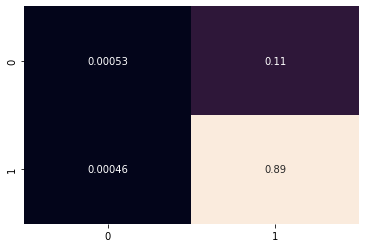

In [ ]:
import seaborn as sns
tr = 0.5
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
cm1 = confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')
sns.heatmap(cm1,annot=True,cbar=False)

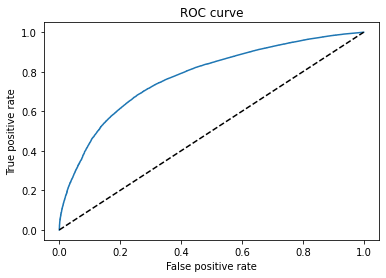

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [ ]:
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.7750725732144411

In [ ]:
Gini = AUROC * 2 - 1
Gini

0.5501451464288822

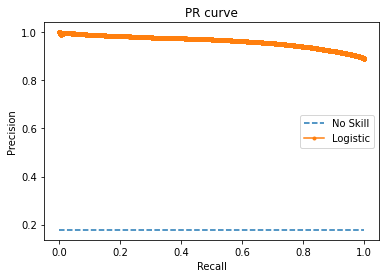

In [ ]:
no_skill = len(y_test[y_test == 1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [ ]:
auc_pr = auc(recall, precision)
auc_pr

0.962307366406332

# Score Card

In [ ]:
summary_table

,Feature name,Coefficients
0,Intercept,3.105895
1,grade:A,0.784128
2,grade:B,0.473708
3,grade:C,0.178159
4,grade:D,-0.010582
...,...,...
67,tot_cur_bal:0-100000,-0.304242
68,tot_cur_bal:100000-200000,-0.303967
69,tot_cur_bal:200000-300000,-0.240322
70,tot_cur_bal:300000-400000,-0.196170


In [ ]:
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
df_ref_categories['Coefficients'] = 0
df_ref_categories

,Feature name,Coefficients
0,"out_prncp:>15,437",0
1,revol_util:>1.0,0
2,inq_last_6mths:>4,0
3,dti:>35.191,0
4,annual_inc:>150K,0
5,int_rate:>20.281,0
6,term:60,0
7,purpose:major_purchcarhome_impr,0
8,verification_status:Not Verified,0
9,home_ownership:MORTGAGE,0


In [ ]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
df_scorecard.reset_index(inplace = True)
df_scorecard

,index,Feature name,Coefficients
0,0,Intercept,3.105895
1,1,grade:A,0.784128
2,2,grade:B,0.473708
3,3,grade:C,0.178159
4,4,grade:D,-0.010582
...,...,...,...
79,7,purpose:major_purchcarhome_impr,0.000000
80,8,verification_status:Not Verified,0.000000
81,9,home_ownership:MORTGAGE,0.000000
82,10,grade:G,0.000000


In [ ]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]
df_scorecard

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,3.105895,Intercept
1,1,grade:A,0.784128,grade
2,2,grade:B,0.473708,grade
3,3,grade:C,0.178159,grade
4,4,grade:D,-0.010582,grade
...,...,...,...,...
79,7,purpose:major_purchcarhome_impr,0.000000,purpose
80,8,verification_status:Not Verified,0.000000,verification_status
81,9,home_ownership:MORTGAGE,0.000000,home_ownership
82,10,grade:G,0.000000,grade


In [ ]:
min_score = 300
max_score = 850

In [ ]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficients'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,3.105895,Intercept,605.765821,606.0
1,1,grade:A,0.784128,grade,55.647116,56.0
2,2,grade:B,0.473708,grade,33.617577,34.0
3,3,grade:C,0.178159,grade,12.643389,13.0
4,4,grade:D,-0.010582,grade,-0.750978,-1.0
...,...,...,...,...,...,...
79,7,purpose:major_purchcarhome_impr,0.000000,purpose,0.000000,0.0
80,8,verification_status:Not Verified,0.000000,verification_status,0.000000,0.0
81,9,home_ownership:MORTGAGE,0.000000,home_ownership,0.000000,0.0
82,10,grade:G,0.000000,grade,0.000000,0.0


In [ ]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
851.0


In [ ]:
pd.options.display.max_rows = 102
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,3.105895,Intercept,605.765821,606.0,0.234179
1,1,grade:A,0.784128,grade,55.647116,56.0,0.352884
2,2,grade:B,0.473708,grade,33.617577,34.0,0.382423
3,3,grade:C,0.178159,grade,12.643389,13.0,0.356611
4,4,grade:D,-0.010582,grade,-0.750978,-1.0,-0.249022
5,5,grade:E,-0.244701,grade,-17.365672,-17.0,0.365672
6,6,grade:F,-0.424959,grade,-30.158040,-30.0,0.158040
7,7,grade:G,-0.622173,grade,-44.153692,-44.0,0.153692
8,8,home_ownership:OWN,0.060282,home_ownership,4.278000,4.0,-0.278000
9,9,home_ownership:MORTGAGE,0.083372,home_ownership,5.916618,6.0,0.083382


In [ ]:
a = df_scorecard.sort_values(['Original feature name', 'Score - Preliminary'])
a = a.drop_duplicates(subset=['Original feature name'], keep='last')
a

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,3.105895,Intercept,605.765821,606.0,0.234179
34,34,"annual_inc:120,379-150,000",0.218318,annual_inc,15.493336,15.0,-0.493336
36,36,dti:<=1.6,0.261809,dti,18.579735,19.0,0.420265
1,1,grade:A,0.784128,grade,55.647116,56.0,0.352884
9,9,home_ownership:MORTGAGE,0.083372,home_ownership,5.916618,6.0,0.083382
45,45,inq_last_6mths:0,0.191107,inq_last_6mths,13.562276,14.0,0.437724
21,21,int_rate:<7.071,0.778898,int_rate,55.275948,55.0,-0.275948
64,64,"out_prncp:9,005-10,291",0.447567,out_prncp,31.762459,32.0,0.237541
18,18,purpose:vacation__house__wedding__med__oth,0.145546,purpose,10.328953,10.0,-0.328953
59,59,revol_util:0.9-1.0,0.338486,revol_util,24.021315,24.0,-0.021315


In [ ]:
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[45, 'Score - Final'] = 13
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,3.105895,Intercept,605.765821,606.0,0.234179,606.0
1,1,grade:A,0.784128,grade,55.647116,56.0,0.352884,56.0
2,2,grade:B,0.473708,grade,33.617577,34.0,0.382423,34.0
3,3,grade:C,0.178159,grade,12.643389,13.0,0.356611,13.0
4,4,grade:D,-0.010582,grade,-0.750978,-1.0,-0.249022,-1.0
5,5,grade:E,-0.244701,grade,-17.365672,-17.0,0.365672,-17.0
6,6,grade:F,-0.424959,grade,-30.158040,-30.0,0.158040,-30.0
7,7,grade:G,-0.622173,grade,-44.153692,-44.0,0.153692,-44.0
8,8,home_ownership:OWN,0.060282,home_ownership,4.278000,4.0,-0.278000,4.0
9,9,home_ownership:MORTGAGE,0.083372,home_ownership,5.916618,6.0,0.083382,6.0


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


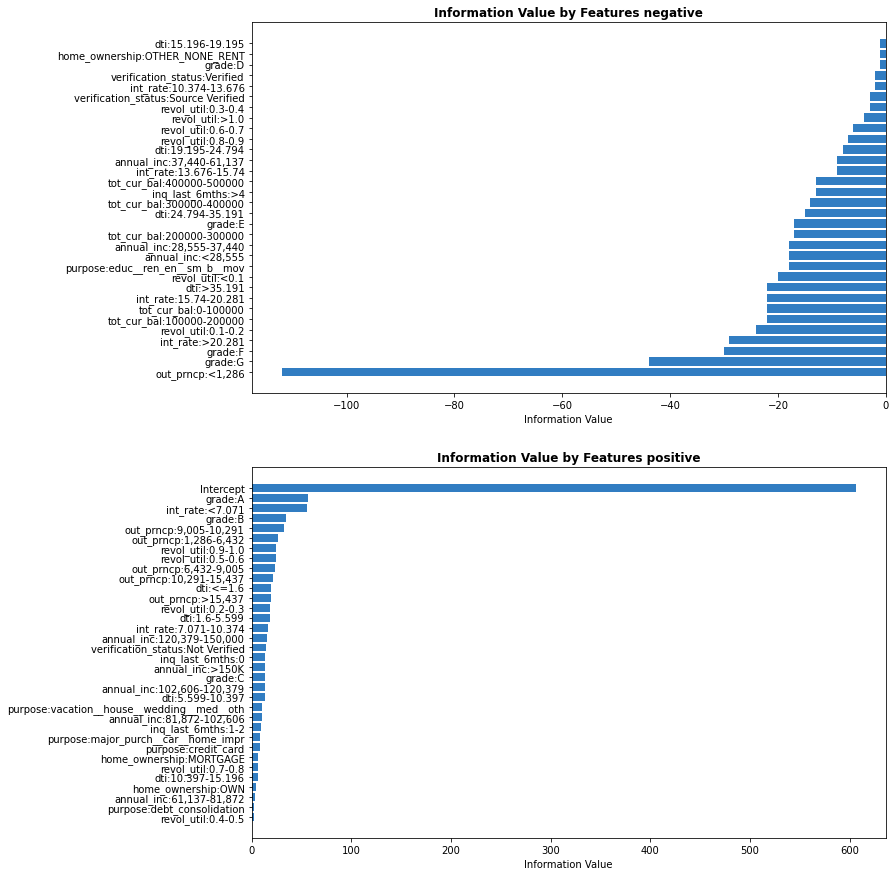

In [ ]:
data2 = df_scorecard[df_scorecard['Score - Final'] < 0]
data2.sort_values(by = 'Score - Final', inplace = True)
data3 = df_scorecard[(df_scorecard['Score - Final'] > 0) & (df_scorecard['Score - Final'] != 598)]
data3.sort_values(by = 'Score - Final', inplace = True)
fig = plt.subplots(figsize=(25,15))
plt.subplot(221)
plt.barh(data2['Feature name'], data2['Score - Final'], color = '#317DC2')
plt.xlabel('Information Value')
plt.title('Information Value by Features negative', fontweight="bold");
plt.subplot(223)
plt.barh(data3['Feature name'], data3['Score - Final'], color = '#317DC2')
plt.xlabel('Information Value')
plt.title('Information Value by Features positive', fontweight="bold");
plt.show()

Del gráfico anterior podemos observar el valor que aporta cada característica al scorcad final, teniendo en cuenta que el valor de referencia es él intercepto. En la GRa´foca superior podemos ver que la característica que más le quita puntaje al cliente en su score es out_pmcp>1,286, seguida por los grados E y F, también se puede observar que la que menos le aporta negativamente es dti:15.196-19.195. En la gráfica inferior se tienen los diferentes pesos que aportan las características a los prestarios de manera positiva, por ejemplo el grado A es la que tiene un aporte de 56 aproximadamente, seguida por int_rate: < 7.071 y gardo B, además se ve que la que tiene un menor aporte de manera positiva es reovol_ultiil:0.4-0.5.

In [ ]:
df_scorecard.to_csv(drive_path + 'scorecard_corregido.csv', index = False)

In [ ]:
print(df_scorecard.groupby('Original feature name')['Score - Final'].min().sum())
print(df_scorecard.groupby('Original feature name')['Score - Final'].max().sum())

300.0
850.0


## Credit Scores para todas las observaciones

In [ ]:
X_test_woe_transformed = woe_transform.fit_transform(X_test)
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:OWN,home_ownership:MORTGAGE,...,"out_prncp:1,286-6,432","out_prncp:6,432-9,005","out_prncp:9,005-10,291","out_prncp:10,291-15,437","out_prncp:>15,437",tot_cur_bal:0-100000,tot_cur_bal:100000-200000,tot_cur_bal:200000-300000,tot_cur_bal:300000-400000,tot_cur_bal:400000-500000
395346,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
376583,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
297790,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
47347,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
446772,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
scorecard_scores = df_scorecard['Score - Final']
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 72)
(84,)


In [ ]:
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
scorecard_scores = scorecard_scores.values.reshape(84, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(93257, 84)
(84, 1)


In [ ]:
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()
y_scores.to_csv(drive_path + 'y_scores.csv', index = False)


In [ ]:
print(y_scores)

            0
395346  471.0
376583  722.0
297790  481.0
47347   502.0
446772  458.0
...       ...
32147   616.0
78936   590.0
459582  446.0
454915  622.0
223621  501.0

[93257 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


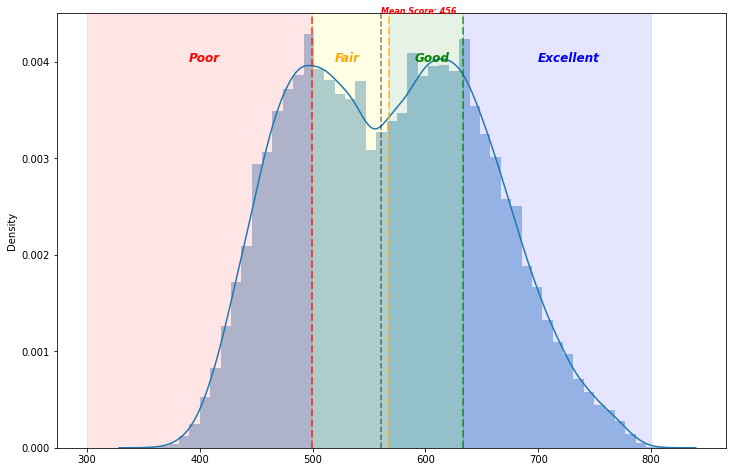

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.distplot(y_scores)
plt.text(561, 0.0045, 'Mean Score: 456', color='red', fontweight='bold', style='italic', fontsize=8)
plt.axvline(561.02417, color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
plt.axvline(np.percentile(y_scores ,25), color='red', linestyle='dashed', linewidth=2, alpha=0.6)
plt.axvline(np.percentile(y_scores,50), color='orange', linestyle='dashed', linewidth=2, alpha=0.6)
plt.axvline(np.percentile(y_scores,75), color='green', linestyle='dashed', linewidth=2, alpha=0.6)

plt.text(390, 0.0040, 'Poor', color='red', fontweight='bold', style='italic', fontsize=12)
plt.text(520, 0.0040, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=12)
plt.text(590, 0.0040, 'Good', color='green', fontweight='bold', style='italic', fontsize=12)
plt.text(700, 0.0040, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=12)

plt.axvspan(300, np.percentile(y_scores ,25), alpha=0.1, color='red')
plt.axvspan(np.percentile(y_scores ,25), np.percentile(y_scores ,50), alpha=0.1, color='yellow')
plt.axvspan(np.percentile(y_scores ,50), np.percentile(y_scores ,75), alpha=0.1, color='green')
plt.axvspan(np.percentile(y_scores ,75), 800, alpha=0.1, color='blue')


plt.show()

In [ ]:
np.percentile(y_scores ,75)

633.0

Del grafico anterior podemos notar que la media del scores es de 456, lo cual se encuentra en el rango má bajo de los puntajes creticios, ya que esta por debajo del quiantil 25, ademas se observa que la distribución del score es bimodal ya que tiene dos picos, uno al rededor de 500 y el segundo al rededor de los 600
